In [1]:
import os
import sqlite3
import pandas as pd
import nltk
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, Flatten, LSTM, Bidirectional
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
import pickle
import re
import random
import numpy as np
import matplotlib.pyplot as plt
import gc
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
import seaborn as sab

Загружаем базу данных.

In [2]:
db_name='../../main_database.sqlite'     
sqlite_db=sqlite3.connect(db_name)
dataBase = pd.read_sql('SELECT * FROM functions', sqlite_db)
sqlite_db.close()

In [3]:
print(dataBase.head())

   id        name  address compiler options libname  \
0   1  .init_proc    12288      gcc     -O0    gzip   
1   2    sub_3020    12320      gcc     -O0    gzip   
2   3    sub_3030    12336      gcc     -O0    gzip   
3   4    sub_3040    12352      gcc     -O0    gzip   
4   5    sub_3050    12368      gcc     -O0    gzip   

                                            assembly  
0  endbr64; _init\nsub     rsp, 8\nmov     rax, c...  
1     push    cs:qword_18D58\nbnd jmp cs:qword_18D60  
2               endbr64\npush    0\nbnd jmp sub_3020  
3               endbr64\npush    1\nbnd jmp sub_3020  
4               endbr64\npush    2\nbnd jmp sub_3020  


In [4]:
print(dataBase.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62339 entries, 0 to 62338
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        62339 non-null  int64 
 1   name      62339 non-null  object
 2   address   62339 non-null  int64 
 3   compiler  62339 non-null  object
 4   options   62339 non-null  object
 5   libname   62339 non-null  object
 6   assembly  62339 non-null  object
dtypes: int64(2), object(5)
memory usage: 3.3+ MB
None


In [5]:
dbCountObjects = dataBase['assembly'].count()   # Количество объектов в базе
dbCountObjects

62339

Делим набор данных и готовим к добавлению в словарь

In [6]:
assembly = pd.DataFrame(dataBase['assembly'], dtype='<U14')['assembly']
compiler = pd.DataFrame(dataBase['compiler'], dtype='<U14')['compiler']

1) Обычный вариант деления данных:

In [7]:
with tf.device('/GPU:0'):
    # Делим набор данных
    assembly_train = assembly[:40000]
    assembly_test = assembly[40000:]
    compiler_train = compiler[:40000]
    compiler_test = compiler[40000:]
    #assembly_train, assembly_test, compiler_train, compiler_test = train_test_split(assembly, compiler, test_size=0.33, shuffle=True)
    
    #Заченяем числа всех систем счисления на "digit"
    assembly_train = assembly_train.apply(lambda element: re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", element)) 
    assembly_test = assembly_test.apply(lambda element: re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", element)) 
    #Заченяем "loc_*" на "loc"
    assembly_train = assembly_train.apply(lambda element: re.sub("loc_[\w]*", "loc", element))
    assembly_test = assembly_test.apply(lambda element: re.sub("loc_[\w]*", "loc", element))
    #Заченяем "var_*" на "var"
    assembly_train = assembly_train.apply(lambda element: re.sub("var_[\w]*", "digit", element))
    assembly_test = assembly_test.apply(lambda element: re.sub("var_[\w]*", "digit", element))

    #Заченяем "gcc" на 1, "clang" на 0
    compiler_train = compiler_train.apply(lambda element: int(re.sub("gcc", "1", element)) if element=="gcc" else int(re.sub("clang", "0", element)))    
    compiler_test = compiler_test.apply(lambda element: int(re.sub("gcc", "1", element)) if element=="gcc" else int(re.sub("clang", "0", element)))    

2) Вариант для KFold

In [ ]:
with tf.device('/GPU:0'):
    # Делим набор данных
    assembly_train = assembly[:dbCountObjects]
    compiler_train = compiler[:dbCountObjects]

    #Заченяем числа всех систем счисления на "digit"
    assembly_train = assembly_train.apply(lambda element: re.sub("\d[A-Fa-f0-9]*[dhbqo]?", "digit", element)) 
    #Заченяем "loc_*" на "loc"
    assembly_train = assembly_train.apply(lambda element: re.sub("loc_[\w]*", "loc", element))
    #Заченяем "var_*" на "var"
    assembly_train = assembly_train.apply(lambda element: re.sub("var_[\w]*", "digit", element))

    #Заченяем "gcc" на 1, "clang" на 0
    compiler_train = compiler_train.apply(lambda element: int(re.sub("gcc", "1", element)) if element=="gcc" else int(re.sub("clang", "0", element)))    

Создаём словарь из набора слов ассемблер-функций

In [8]:
# Tokenizer убирает символы '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', а разделителем слов является пробел
tokenizer = Tokenizer(split=' ',char_level=False, oov_token='<OOV>')

if (os.path.exists('.\\TokenizedDictionary') == True):   # Если словарь уже создан - загружаем его
    with open('.\\TokenizedDictionary', 'rb') as handle:
        tokenizer = pickle.load(handle)
else:    # Иначе - заполняем словарь
    with tf.device('/GPU:0'):
        assembly_train.apply(lambda element: tokenizer.fit_on_texts([element]))    #Добавляем слова в словарь

In [176]:
with open('TokenizedDictionary', 'wb') as handle:               # Сохранение словаря
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [9]:
word_indexes = tokenizer.word_index
print(word_indexes)

{'<OOV>': 1, 'digit': 2, 'mov': 3, 'loc': 4, 'rax': 5, 'rdigit': 6, 'rbp': 7, 'eax': 8, 'rdi': 9, 'short': 10, 'ptr': 11, 'call': 12, 'rbx': 13, 'cmp': 14, 'rsp': 15, 'jz': 16, 'rdx': 17, 'rcx': 18, 'test': 19, 'rsi': 20, 'jmp': 21, 'lea': 22, 'edx': 23, 'ecx': 24, 'add': 25, 'push': 26, 'jnz': 27, 'xor': 28, 'pop': 29, 'esi': 30, 'xmmdigit': 31, 'dword': 32, 'qword': 33, 'byte': 34, 'edi': 35, "'": 36, 'cs': 37, 'movzx': 38, 'sub': 39, 'al': 40, 'retn': 41, 'ebx': 42, 'ebp': 43, 'internal': 44, 'int': 45, 'alias': 46, 's': 47, 'ctxt': 48, 'and': 49, 'jumptable': 50, 'xmmword': 51, 'cl': 52, 'movsxd': 53, 'endbrdigit': 54, 'case': 55, 'n': 56, 'word': 57, 'movups': 58, 'dl': 59, 'nop': 60, 'name': 61, 'shl': 62, 'or': 63, 'ja': 64, 'jle': 65, 'error': 66, 'is': 67, 'xmlfree': 68, 'ds': 69, 'png': 70, 'shr': 71, 'jbe': 72, 'locret': 73, 'src': 74, 'alternative': 75, 'jnb': 76, 'cases': 77, 'offset': 78, 'xmlstrequal': 79, 'jg': 80, 'intdigit': 81, 'cur': 82, 'default': 83, 'jb': 84, 'fo

Подготовка данных для обучения:

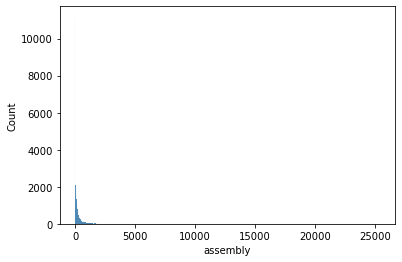

In [10]:
# Смотрим на длины токенизированных ассемблеров 
length = assembly_train.apply(lambda element: len(tokenizer.texts_to_sequences([element])[0]))
a = sab.histplot(length)
    

In [11]:
minLen = 10     # Мин. кол-во токенов ассемблерной функции
maxLen = 200   # Макс. кол-во токенов 
maxDim = 13314  # Размер словаря (общее кол-во токенов)

In [12]:
def prepareDataForLearning(dataX, dataY):
    # переводим ассемблер в токены
    tokenizedAssemb = dataX.apply(lambda element: tokenizer.texts_to_sequences([element])[0])
    # отсекаем маленькие функции
    tokenizedAssemb = tokenizedAssemb.apply(lambda element: 0 if len(element) < minLen else element)
    tokenizedAssemb = tokenizedAssemb.drop(tokenizedAssemb[tokenizedAssemb == 0].index)
    # обрезаем большие функции
    tokenizedAssemb = tokenizedAssemb.apply(lambda element: element[:maxLen] if len(element) > maxLen else element)
    
    # Записываем данные в numpy массивы
    resultX = np.zeros((tokenizedAssemb.shape[0], maxLen))
    resultY = np.zeros((tokenizedAssemb.shape[0]))
    counter = 0
    for i in tokenizedAssemb.index:
        resultX[counter][:len(tokenizedAssemb[i])] = tokenizedAssemb[i]
        resultY[counter] = dataY[i]
        counter += 1
    # перемешиваем набор данных
    shuffled_indexes = list(range(0, tokenizedAssemb.shape[0]))
    random.shuffle(shuffled_indexes)
    # удаляем временную переменную
    del tokenizedAssemb
    gc.collect()
    return resultX[shuffled_indexes], resultY[shuffled_indexes]

In [13]:
with tf.device('/GPU:0'):
    x_train, y_train = prepareDataForLearning(assembly_train, compiler_train)
    x_test, y_test = prepareDataForLearning(assembly_test, compiler_test)

In [14]:
print(x_train.shape)
print(y_train.shape)

(30672, 200)
(30672,)


Проектирование модели нейронной сети:

In [22]:
a1 = Embedding(
    input_dim=maxDim, output_dim=100, input_length=maxLen)
a2 = Bidirectional(LSTM(10, input_shape=(maxLen, 100)))
a3 = Dense(1, activation='sigmoid')

In [23]:
model = Sequential()
model.add(a1)          
model.add(a2)          
#model.add(Flatten())
model.add(a3)

In [17]:
# загрузка сохранённой модели
model = keras.models.load_model('.\\model')   

In [24]:
model.summary()    # Embbeding: выход: (batch, assembLeght(Tokenized)=10000, features=30)
                   # Вход LSTM: (batch, timesteps, features): в роли timesteps - токенизированные слова ассемблера;
                   # в роли features - embedding-вектор, описывающий токенизированное слово

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 200, 100)          1331400   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 20)                8880      
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 1,340,301
Trainable params: 1,340,301
Non-trainable params: 0
_________________________________________________________________


In [25]:
optim = keras.optimizers.Adam(learning_rate=0.01)
model.compile(optimizer=optim, loss='binary_crossentropy',metrics=['accuracy'])

Обучение:

In [26]:
test_accuracy = []
test_loss = []
class metrics_on_test(keras.callbacks.Callback):
    def __init__(self, model, x_test, y_test):
        self.model = model
        self.x_test = x_test
        self.y_test = y_test

    def on_epoch_end(self, epoch, logs={}):
        metrics_test = self.model.evaluate(self.x_test, self.y_test, batch_size=800)
        test_loss.append(metrics_test[0])
        test_accuracy.append(metrics_test[1])

In [27]:
test_accuracy = []
test_loss = []
with tf.device('/GPU:0'):
    history2 = model.fit(
        x_train, 
        y_train,
        batch_size=400, 
        epochs=20, 
        callbacks=
            [EarlyStopping(monitor='loss', min_delta=0.001, mode='min', patience=2),
             metrics_on_test(model, x_test,y_test),
             #ModelCheckpoint(filepath='.\\model'),
             ReduceLROnPlateau(monitor="loss", patience=1, min_lr=0.0001)])

Epoch 1/20
26/26 [==============================] - 3s 51ms/step - loss: 0.0770 - accuracy: 0.9873
Epoch 2/20
26/26 [==============================] - 1s 49ms/step - loss: 0.0637 - accuracy: 0.9858 0s - loss: 0.0652 
Epoch 3/20
26/26 [==============================] - 1s 50ms/step - loss: 0.0619 - accuracy: 0.9865
Epoch 4/20
26/26 [==============================] - 1s 51ms/step - loss: 0.0671 - accuracy: 0.9792
Epoch 5/20
26/26 [==============================] - 1s 51ms/step - loss: 0.0455 - accuracy: 0.9873
Epoch 6/20
26/26 [==============================] - 1s 51ms/step - loss: 0.0618 - accuracy: 0.9815
Epoch 7/20
26/26 [==============================] - 1s 51ms/step - loss: 0.0521 - accuracy: 0.9839
Epoch 8/20
26/26 [==============================] - 1s 52ms/step - loss: 0.0695 - accuracy: 0.9796
Epoch 9/20
26/26 [==============================] - 1s 51ms/step - loss: 0.0667 - accuracy: 0.9816
Epoch 10/20
26/26 [==============================] - 1s 52ms/step - loss: 0.0729 - accurac

In [39]:
model.save('.\\model')

INFO:tensorflow:Assets written to: .\model\assets


INFO:tensorflow:Assets written to: .\model\assets


In [40]:
history2.history

{'loss': [0.2768685817718506,
  0.15689343214035034,
  0.12660367786884308,
  0.10786348581314087,
  0.0913904458284378,
  0.08438451588153839,
  0.07915748655796051,
  0.06981261074542999,
  0.07478778809309006,
  0.059894513338804245,
  0.05652245506644249,
  0.054726745933294296,
  0.053675659000873566,
  0.052252501249313354,
  0.05155076086521149,
  0.050847239792346954,
  0.05013659596443176,
  0.049069471657276154,
  0.048366475850343704,
  0.04734937101602554],
 'accuracy': [0.8892801403999329,
  0.9360328912734985,
  0.9470200538635254,
  0.950867235660553,
  0.9555946588516235,
  0.9586919546127319,
  0.9614306092262268,
  0.9643648862838745,
  0.9635823965072632,
  0.9704290628433228,
  0.9712115526199341,
  0.9716353416442871,
  0.9715375304222107,
  0.972776472568512,
  0.9736241698265076,
  0.9732329249382019,
  0.9736567735671997,
  0.9744392037391663,
  0.9738523960113525,
  0.9744718074798584],
 'lr': [0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.01,
  0.0

Значения функция на тестовом датасете

In [41]:
with tf.device('/GPU:0'):
    loss_metric_test = model.evaluate(x_test,y_test,batch_size=800)

26/26 [==============================] - 2s 45ms/step - loss: 0.0705 - accuracy: 0.9814


Графики:

In [55]:
X = range(1,21)

1) Функция потерь и accuracy

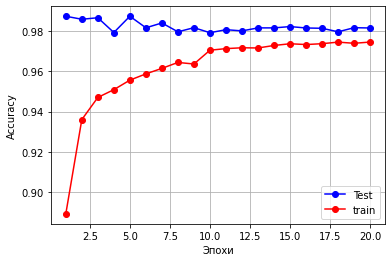

In [56]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(X, test_accuracy, 'o-', color='blue', label='Test')
ax1.plot(X, history2.history['accuracy'], 'o-', color='red', label='train')
ax1.grid()
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Accuracy')
ax1.legend()

plt.show()

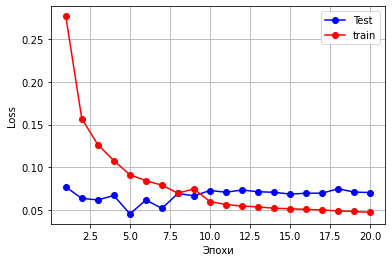

In [57]:
fig, ax2 = plt.subplots(1, 1)
ax2.plot(X, test_loss, 'o-', color='blue', label='Test')
ax2.plot(X, history2.history['loss'], 'o-', color='red', label='train')
ax2.grid()
ax2.set_xlabel('Эпохи')
ax2.set_ylabel('Loss')
ax2.legend()

plt.show()

2) Матрица ошибок

In [51]:
def getPredictionMatrix(y_value, y_prediction):
    result = [[0,0],
              [0,0]]
    indexes_y_0 = [i for i in range(0, y_value.shape[0]) if y_value[i] == 0]
    indexes_y_1 = [i for i in range(0, y_value.shape[0]) if y_value[i] == 1]
    result[0][0] = (y_value[indexes_y_0] == y_prediction.round()[indexes_y_0, 0]).sum()
    result[0][1] = (y_value[indexes_y_0] != y_prediction.round()[indexes_y_0, 0]).sum()
    result[1][0] = (y_value[indexes_y_1] != y_prediction.round()[indexes_y_1, 0]).sum()
    result[1][1] = (y_value[indexes_y_1] == y_prediction.round()[indexes_y_1, 0]).sum()
    return result

In [52]:
prediction_matrix = getPredictionMatrix(y_test, model.predict(x_test))

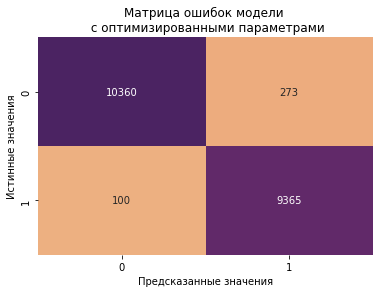

In [53]:
sab.heatmap(prediction_matrix, annot=True, fmt='.7g', cmap='flare', cbar=False)
plt.xlabel('Предсказанные значения')
plt.ylabel('Истинные значения')
plt.title('Матрица ошибок модели \n с оптимизированными параметрами')
plt.show()

3) Изменение шага обучения

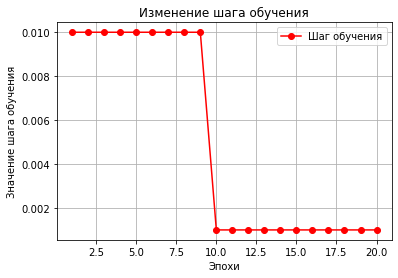

In [58]:
fig, ax1 = plt.subplots(1, 1)
ax1.plot(X, history2.history['lr'], 'o-', color='red', label='Шаг обучения')
ax1.grid()
ax1.set_xlabel('Эпохи')
ax1.set_ylabel('Значение шага обучения')
ax1.legend()

plt.title('Изменение шага обучения')
plt.show()